In [1]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
import warnings
from typing import List, Tuple, Dict
%matplotlib inline

In [2]:
plt.style.use("bmh")

## Class

In [146]:
class Somatic_LS(object):
    def __init__(
        self, 
        organ:str='liver', 
        method:str='RK45', 
        start_time:float=0, 
        end_time:float=300, 
        include_mutants:bool=False, 
        equation:str='single',
        print_config:bool=True):

        self.method = method
        self.organ = organ
        self.conf = self.set_config()
        if not include_mutants:
            self.conf[-1] = 0
            self.conf[-2] = 0

        coeff = 21.5 / (365.25 * 24)
        self.start = int(start_time / coeff)
        self.end = int(np.round(end_time / coeff))
        self.span = -self.start + self.end
        self.t = np.linspace(self.start, self.end, self.end - self.start)
        self.include = include_mutants
        self.equation = equation

        if method != 'RK45':
            warnings.warn(f'Using {method} as a solver for solve_ivp. Consider using RK45 as the most stable solver')
        
        if (self.organ == 'spinal cord')&(self.equation == 'two'):
            raise ValueError('No two-equation system for spinal cord. Consider using only single-equation.')

        if print_config: self._print_config()

    def _print_config(self) -> None:
        print(f'''
              CONFIG FOR SIMULATION HAS BEEN CREATED
              {'-'*40}
              Final parameters set:
              --organ: {self.organ},
              --start: {np.round(self.start*(21.5 / (365.25 * 24)))} years,
              --end: {np.round(self.end*(21.5 / (365.25 * 24)))} years,
              --type of system: {self.equation} equation system,
              --solver method: {self.method},
              --include mutants: {self.include}
              {'-'*40}
              ''')
    
    def set_config(self) -> List:
        configs = {
            'liver': [0.087, 2e11, 2e11/94000, 4/407, 0.064, (3.5e-9)*9.6e-3, (1.83e-9)*9.6e-3, 4/407, 0.9, 0.239],
            'mouse liver': [0.087, 3.37e8, 3.37e8/94000, 63/407, 0.064, 35*(3.5e-9), 35*(1.83e-9), 63/407, 0.9, 0.239],
            'lungs': [0.073, 10.5e9, 0.07*10.5e9, 0.001/407, 0.007, 6.392476819356688e-12, 6.392476819356688e-12 / 1.9126, 0.001/407, 0.9, 0.239],
            'spinal cord': [0.085, 222e6, 0, 0, 0, 0.9047619*(3.5e-9)*0.0013563, 0, 0, 0.9, 0.239]
        }
        return configs.get(self.organ, configs['liver'])
    
    def model_one(self, t, y, s, K, M, r, e, a, b, g, z, d) -> List:
        X, C, F = y
        m1 = 0.5 * s * (1 - X / K)
        dXdt = r * X * (1 - X / K) - a * X - m1 * ((C + (1 - z) * a * X * t + d * C * t) ** 2)
        dCdt = r * C * (1 - C / K) + z * a * X - d * C
        dFdt = (1 - z) * a * X + d * C
        return [dXdt, dCdt, dFdt]

    def model_two(self, t, y, s, K, M, r, e, a, b, g, z, d) -> List:
        X, Y, m = y
        m1 = 0.5 * s * (1 - (X + Y) / (K + M))
        dXdt = r * X * (1 - X / K) + 2 * e * Y - a * X - m1 * ((a * X + b * Y) ** 2 * t ** 2)
        dYdt = g * Y * (1 - Y / M) - e * Y - b * Y
        dmdt = 0.5 * s * (1 - (X + Y) / (K + M)) * ((a * X + b * Y) ** 2 * t ** 2)
        return [dXdt, dYdt, dmdt]
    
    def get_initial_conditions(self) -> List:
        K = self.conf[1]
        M = self.conf[2]
        if self.equation == 'single':
            initial = {
                'liver': [0.31*K, 0, 0],
                'lungs': [0.78*K, 0, 0],
                'spinal cord': [K, 0, 0],
                'mouse liver': [0.31*K, 0, 0]
            }
        elif self.equation == 'two':
            if self.organ == 'spinal cord':
                raise ValueError('No two-equation system for spinal cord. Consider using single equation')
            initial = {
                'liver': [0.31*K, 0.31*M, 0],
                'lungs': [0.78*K, 0.78*M, 0],
                'mouse liver': [0.31*K, 0.31*M, 0]
            }
        return initial.get(self.organ, initial['liver'])
    
    def get_model(self):
        if self.equation == 'single':
            return self.model_one
        elif self.equation == 'two':
            if self.organ == 'spinal cord':
                raise ValueError('No two-equation system for spinal cord. Consider using single equation')
            return self.model_two

    def calculate_population(self):
        conf = tuple(self.conf)
        initial = self.get_initial_conditions()
        model = self.get_model()
        solution = solve_ivp(model,t_span=(self.start, self.end), y0=initial, t_eval=self.t, method = self.method,args=conf, dense_output=True)
        return solution  
    
    def get_threshold(self) -> Dict:
        thr = {
            'liver': 0.3,
            'mouse liver': 0.3,
            'lungs': 0.4,
            'spinal cord': 0.9
        }
        return thr.get(self.organ, thr['liver'])

    def lifespan(
        self, 
        custom_solution = None) -> int:

        K = self.conf[1]

        if custom_solution is not None:
            arr = custom_solution
        else:
            arr = self.calculate_population()
        
        thr = self.get_threshold()

        l = [i for i in range(self.span) if arr.y[0][i]/K <= thr]
        k = [i for i in range(self.span) if arr.y[0][i]/K > 0.99]

        if len(l) != 0:
            print('Life expentancy (years):', np.round((l[0]*21.5)/(365.25*24)))
            print('-'*50)
            ls = l[0]
        else:
            print('Havent died')
            print('-'*50)
            ls = []

        if len(k) != 0:
            if arr.y[0][0] == K:
                print('No resection')
            else:
                print('Time of regeneration of somatic cells (years):', np.round((k[0]*21.5)/(365.25*24), 2))
        else:
            if arr.y[0][0] != K:
                print('Havent regenerated')

        return ls
    
    def plot_curves(
        self, 
        population:str = 'somatic', 
        view_all:bool = False, 
        proportions:bool = False, 
        plot_thr:bool = False) -> None:

        arr = self.calculate_population()
        life = self.lifespan()
        thr  = self.get_threshold()
        K = self.conf[1]

        if self.equation == 'single':
            if population == 'somatic':
                Y = arr.y[0]
            elif population == 'alive mutants':
                Y = arr.y[1]
            elif population == 'dead mutants':
                Y = arr.y[2]
            elif (population == 'mortality function'):
                raise ValueError('Mortality function in single equation system is not implemented. Consider using two equation system only.')
        
        elif self.equation == 'two':
            if population == 'somatic':
                Y = arr.y[0]
            elif population == 'stem':
                Y = arr.y[1]
            elif population == 'mortality function':
                Y = arr.y[2]
                deriv = np.diff(Y)

                maximum = np.argmax(deriv)
                max_der = np.max(deriv)

                _, axes = plt.subplots(1, 2, figsize = (12,8))

                axes[0].plot(self.t*21.5/(365.25*24), Y)
                axes[1].plot(self.t[:-1]*21.5/(365.25*24), deriv)

                axes[0].grid('True')
                axes[1].grid('True')

                axes[1].set_xlabel('Years')
                axes[1].set_ylabel('dM/dt')

                axes[0].set_xlabel('Years')
                axes[0].set_ylabel('M(t)')

                axes[0].set_title('Mortality function')
                axes[1].set_title('Mortality function derivative')

                axes[0].axvline(maximum*21.5/(365.25*24), color = 'r', ls = '--')

                axes[1].axvline(maximum*21.5/(365.25*24), color = 'r', ls = '--')
                axes[1].axhline(max_der, ls = '-.', color = 'g')

                print('Max:', np.round(maximum*21.5/(365.25*24), 0))
                print('Max deriv:', np.round(max_der, 0))
                print('Ratio of max deriv to total lifespan in %:', np.round((maximum*21.5/(365.25*24))/((life*21.5)/(365.25*24))*100, 1))

                return None
        
        if proportions:
            plt.plot(self.t*21.5/(365.25*24), Y/K, label = population)
            if plot_thr:
                plt.axhline(thr, ls = '--', color = 'r')
        else:
            plt.plot(self.t*21.5/(365.25*24), Y, label = population)
            if plot_thr:
                plt.axhline(thr*K, ls = '--', color = 'r')
        plt.xlabel('Years')
        plt.ylabel('Population')
        if not view_all:
            plt.xlim(self.start, life*21.5/(365.25*24))
        plt.legend()
        plt.grid('True')
        plt.show()
    
    def variator(
        self, 
        fraction:float = 5, 
        sampling_freq:int = 4, 
        x_bound:float = 300, 
        only_z:bool=False, 
        only_r:bool=False, 
        only_sigma:bool=False, 
        only_alpha:bool=False, 
        z_min:float=0.1, 
        z_max:float=0.9,
        d_min:float=0.1,
        d_max:float=0.9, 
        legend:bool=True) -> None:
        
        init = self.get_initial_conditions()
        thr = self.get_threshold()
        K = self.conf[1]
        model = self.get_model()
        config_ = self.conf

        if only_r:
            self._vary_parameter('r', 3, fraction, sampling_freq, model, init, thr*K, x_bound, legend,config_)
        elif only_alpha:
            self._vary_parameter('alpha', 5, fraction, sampling_freq, model, init, thr*K, x_bound, legend, config_)
        elif only_sigma:
            self._vary_parameter('sigma', 0, fraction, sampling_freq, model, init, thr*K, x_bound, legend, config_)
        elif only_z:
            self._vary_z_parameter(z_min, z_max, sampling_freq, model, init, thr*K, x_bound, legend, config_)
        else:
            if self.equation == 'two':
                sols_sigma_ = []
                sigma_range_ = np.linspace(self.conf[0]/fraction, fraction*self.conf[0], sampling_freq)       
                sols_alpha_ = []
                alpha_range_ = np.linspace(self.conf[5]/fraction, fraction*self.conf[5], sampling_freq)       
                sols_beta_ = []
                beta_range_ = np.linspace(self.conf[6]/fraction, fraction*self.conf[6], sampling_freq)        
                sols_epsilon_ = []
                eps_range_ = np.linspace(self.conf[4]/fraction, fraction*self.conf[4], sampling_freq)   

                for sigma1 in sigma_range_:
                    conf_sigma = self.conf.copy()
                    conf_sigma[0] = sigma1
                    solution3_ = solve_ivp(model,t_span=(self.start, self.end), y0=init, t_eval=self.t, method = 'RK45',args=tuple(conf_sigma), dense_output=True)
                    sols_sigma_.append(solution3_)   

                for a1 in alpha_range_:
                    conf_alpha = self.conf.copy()
                    conf_alpha[5] = a1
                    solution4_ = solve_ivp(model,t_span=(self.start, self.end), y0=init, t_eval=self.t, method = 'RK45',args=tuple(conf_alpha), dense_output=True)
                    sols_alpha_.append(solution4_)   

                for b1 in beta_range_:
                    conf_beta = self.conf.copy()
                    conf_beta[6] = b1
                    solution5_ = solve_ivp(model,t_span=(self.start, self.end), y0=init, t_eval=self.t, method = 'RK45',args=tuple(conf_beta), dense_output=True)
                    sols_beta_.append(solution5_) 

                for e1 in eps_range_:
                    conf_eps = self.conf.copy()
                    conf_eps[4] = e1
                    solution6_ = solve_ivp(model,t_span=(self.start, self.end), y0=init, t_eval=self.t, method = 'RK45',args=tuple(conf_eps), dense_output=True)
                    sols_epsilon_.append(solution6_)  

                fig, ax = plt.subplots(2, 2, figsize = (20,14))  

                for i in range(len(sols_sigma_)):
                    ax[0][0].plot(self.t*21.5/(365.25*24), sols_sigma_[i].y[0], label = f'Somatic population for sigma = {np.round(sigma_range_[i], 4)}')   

                for i in range(len(sols_alpha_)):
                    ax[0][1].plot(self.t*21.5/(365.25*24), sols_alpha_[i].y[0], label = f'Somatic population for alpha = {np.round(alpha_range_[i], 13)}')  

                for i in range(len(sols_beta_)):
                    ax[1][0].plot(self.t*21.5/(365.25*24), sols_beta_[i].y[0], label = 'Somatic population for betas')      

                for i in range(len(sols_epsilon_)):
                    ax[1][1].plot(self.t*21.5/(365.25*24), sols_epsilon_[i].y[0], label = f'Somatic population for epsilon = {np.round(eps_range_[i], 13)}')  

                ax[0][0].grid('True')
                ax[0][1].grid('True')
                ax[1][0].grid('True')
                ax[1][1].grid('True')      

                ax[0][0].set_xlabel('Years')
                ax[0][1].set_xlabel('Years')
                ax[1][0].set_xlabel('Years')
                ax[1][1].set_xlabel('Years')   

                ax[0][0].set_ylabel('Population')
                ax[0][1].set_ylabel('Population')
                ax[1][0].set_ylabel('Population')
                ax[1][1].set_ylabel('Population')   

                ax[0][0].set_title('Population number for different sigmas')
                ax[0][1].set_title('Population number for different somatic mutation rates')
                ax[1][0].set_title('Population number for different stem cell mutation rates')
                ax[1][1].set_title('Population number for different proliferation rates')     

                ax[0][0].set_xlim(0,x_bound)
                ax[0][1].set_xlim(0,x_bound)
                ax[1][0].set_xlim(0,x_bound)
                ax[1][1].set_xlim(0,x_bound)  

                ax[0][0].axhline(thr*K, ls = '--', color = 'r')
                ax[0][1].axhline(thr*K, ls = '--', color = 'r')
                ax[1][0].axhline(thr*K, ls = '--', color = 'r')
                ax[1][1].axhline(thr*K, ls = '--', color = 'r')  

                if legend:
                    ax[0][0].legend(loc = 'upper right')
                    ax[0][1].legend(loc ='upper right')     
                    ax[1][1].legend(loc = 'upper right')

            elif self.equation == 'single':
                sols_sigma_ = []
                sigma_range_ = np.linspace(self.conf[0]/fraction, fraction*self.conf[0], sampling_freq)       
                sols_alpha_ = []
                alpha_range_ = np.linspace(self.conf[5]/fraction, fraction*self.conf[5], sampling_freq)       
                sols_d_ = []
                d_range_ = np.linspace(d_min, d_max, sampling_freq)      
                sols_z_ = []
                z_range_ = np.linspace(z_min, z_max, sampling_freq)  

                for sigma1 in sigma_range_:
                    conf_sigma = self.conf.copy()
                    conf_sigma[0] = sigma1
                    solution3_ = solve_ivp(model,t_span=(self.start, self.end), y0=init, t_eval=self.t, method = 'RK45',args=tuple(conf_sigma), dense_output=True)
                    sols_sigma_.append(solution3_)  

                for a1 in alpha_range_:
                    conf_alpha = self.conf.copy()
                    conf_alpha[5] = a1
                    solution4_ = solve_ivp(model,t_span=(self.start, self.end), y0=init, t_eval=self.t, method = 'RK45',args=tuple(conf_alpha), dense_output=True)
                    sols_alpha_.append(solution4_)   

                for d1 in d_range_:
                    conf_beta = self.conf.copy()
                    conf_beta[-1] = d1
                    solution5_ = solve_ivp(model,t_span=(self.start, self.end), y0=init, t_eval=self.t, method = 'RK45',args=tuple(conf_beta), dense_output=True)
                    sols_d_.append(solution5_) 

                for z1 in z_range_:
                    conf_eps = self.conf.copy()
                    conf_eps[-2] = z1
                    solution6_ = solve_ivp(model,t_span=(self.start, self.end), y0=init, t_eval=self.t, method = 'RK45',args=tuple(conf_eps), dense_output=True)
                    sols_z_.append(solution6_)  

                fig, ax = plt.subplots(2, 2, figsize = (20,14))   

                for i in range(len(sols_sigma_)):
                    ax[0][0].plot(self.t*21.5/(365.25*24), sols_sigma_[i].y[0], label = f'Somatic population for sigma = {np.round(sigma_range_[i], 4)}')  

                for i in range(len(sols_alpha_)):
                    ax[0][1].plot(self.t*21.5/(365.25*24), sols_alpha_[i].y[0], label = f'Somatic population for alpha = {np.round(alpha_range_[i], 13)}')

                for i in range(len(sols_d_)):
                    ax[1][0].plot(self.t*21.5/(365.25*24), sols_d_[i].y[0], label = f'Somatic population for d = {np.round(d_range_[i], 3)}')  

                for i in range(len(sols_z_)):
                    ax[1][1].plot(self.t*21.5/(365.25*24), sols_z_[i].y[0], label = f'Somatic population for z = {np.round(z_range_[i], 3)}') 

                ax[0][0].grid('True')
                ax[0][1].grid('True')
                ax[1][0].grid('True')
                ax[1][1].grid('True') 

                ax[0][0].set_xlabel('Years')
                ax[0][1].set_xlabel('Years')
                ax[1][0].set_xlabel('Years')
                ax[1][1].set_xlabel('Years')   

                ax[0][0].set_ylabel('Population')
                ax[0][1].set_ylabel('Population')
                ax[1][0].set_ylabel('Population')
                ax[1][1].set_ylabel('Population')    

                ax[0][0].set_title('Population number for different sigmas')
                ax[0][1].set_title('Population number for different somatic mutation rates')
                ax[1][0].set_title('Population number for different alive mutants death rate')
                ax[1][1].set_title('Population number for different proportion of alive mutants')  

                ax[0][0].set_xlim(0,x_bound)
                ax[0][1].set_xlim(0,x_bound)
                ax[1][0].set_xlim(0,x_bound)
                ax[1][1].set_xlim(0,x_bound)    

                ax[0][0].axhline(thr*K, ls = '--', color = 'r')
                ax[0][1].axhline(thr*K, ls = '--', color = 'r')
                ax[1][0].axhline(thr*K, ls = '--', color = 'r')
                ax[1][1].axhline(thr*K, ls = '--', color = 'r')     
                
                if legend:
                    ax[0][0].legend(loc = 'upper right')
                    ax[0][1].legend(loc ='upper right') 
                    ax[1][0].legend(loc = 'upper right')
                    ax[1][1].legend(loc = 'upper right')    


    def _vary_parameter(self, param_name, param_index, fraction, sampling_freq, model, initial_conditions, threshold, x_bound, legend, config):
        param_range = np.linspace(self.conf[param_index] / fraction, fraction * self.conf[param_index], sampling_freq)
        solutions = []

        for param_value in param_range:
            conf = config.copy()
            conf[param_index] = param_value
            solution = solve_ivp(model, t_span=(self.start, self.end), y0=initial_conditions, t_eval=self.t, method=self.method, args=tuple(conf), dense_output=True)
            solutions.append(solution)
        
        ls = self.lifespan(solutions[-1])

        self._plot_variation(solutions, param_range, param_name, threshold, x_bound, legend)
    
    def _vary_z_parameter(self, z_min, z_max, steps, model, initial_conditions, threshold, x_bound, legend, config):
        if self.equation == 'two':
            raise ValueError('No alive mutants in two equation model. Consider using single equation.')
    
        z_range = np.linspace(z_min, z_max, steps)
        solutions = []
    
        for z_value in z_range:
            conf = config.copy()
            conf[-2] = z_value
            solution = solve_ivp(model, t_span=(self.start, self.end), y0=initial_conditions, t_eval=self.t, method=self.method, args=tuple(conf), dense_output=True)
            solutions.append(solution)
    
        self._plot_variation(solutions, z_range, 'alive mutants proportion', threshold, x_bound, legend)
    
    def _plot_variation(self, solutions, param_range, param_name, threshold, x_bound, legend):
        fig, ax = plt.subplots(figsize=(12, 8))

        for solution, param_value in zip(solutions, param_range):
            ax.plot(self.t * 21.5 / (365.25 * 24), solution.y[0], label=f'{param_name} = {np.round(param_value, 7)}')

        self._finalize_plot(ax, param_name, threshold, x_bound, legend)
        
    def _finalize_plot(self, ax, param_name, threshold, x_bound, legend):
        ax.grid(True)
        ax.set_xlabel('Years')
        ax.set_ylabel('Population')
        ax.set_xlim(0, x_bound)
        ax.axhline(threshold, ls='--', color='r')
        if legend:
            ax.legend(loc='upper right')
        plt.show()

## Exp


In [147]:
z = Somatic_LS(organ = 'liver',equation = 'single', end_time = 300, include_mutants=True)


              CONFIG FOR SIMULATION HAS BEEN CREATED
              ----------------------------------------
              Final parameters set:
              --organ: liver,
              --start: 0.0 years,
              --end: 300.0 years,
              --type of system: single equation system,
              --solver method: RK45,
              --include mutants: True
              ----------------------------------------
              


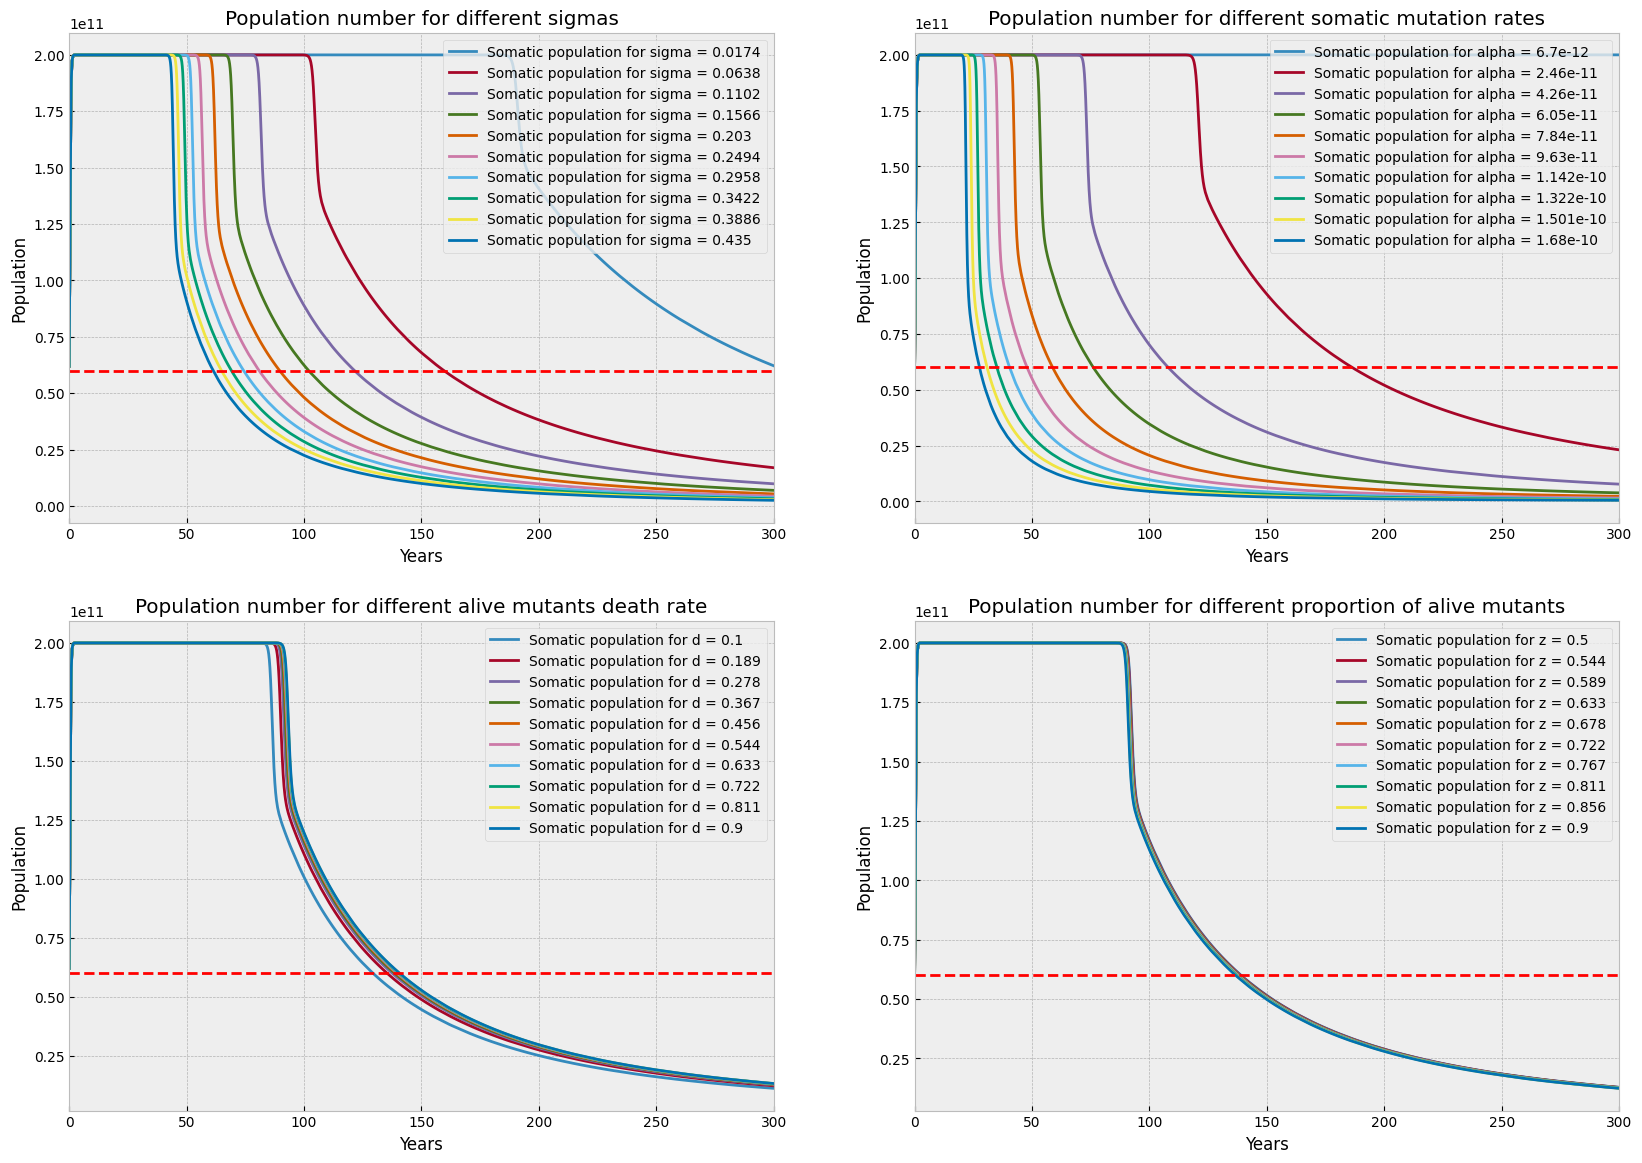

In [148]:
z.variator(x_bound=300, d_max=0.9, d_min=0.1, sampling_freq=10, z_min=0.5, z_max=0.9)